# Optimisation et méthodes de gradient en Python

Ce notebook implémente :
1. La descente de gradient à pas fixe
2. La méthode du gradient conjugué
3. RMSProp
4. Adam

Nous allons comparer leurs performances sur une fonction quadratique simple.

In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Génération de données pour un problème quadratique
np.random.seed(0)
n_features = 50
n_samples = 200

X = np.random.randn(n_samples, n_features)
true_w = np.random.randn(n_features)
y = X @ true_w + 0.1 * np.random.randn(n_samples)  # bruit

## Fonction quadratique et gradient

In [3]:
def F(w):
    return 0.5 * norm(X @ w - y)**2

def grad_F(w):
    return X.T @ (X @ w - y)

# Lipschitz constant
L = np.linalg.norm(X.T @ X, 2)  # norme spectrale
print("Lipschitz constant L:", L)

Lipschitz constant L: 434.4444463153616


## Descente de gradient à pas fixe

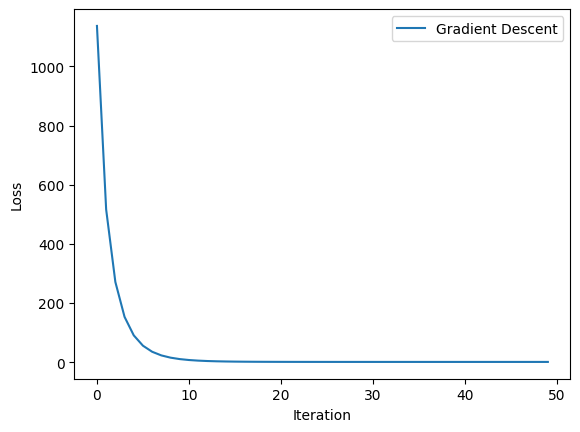

In [4]:
def gradient_descent(w0, lr, n_iter):
    w = w0.copy()
    losses = []
    for _ in range(n_iter):
        w -= lr * grad_F(w)
        losses.append(F(w))
    return w, losses

w0 = np.zeros(n_features)
w_gd, losses_gd = gradient_descent(w0, lr=1/L, n_iter=50)
plt.plot(losses_gd, label='Gradient Descent')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Méthode du Gradient Conjugué

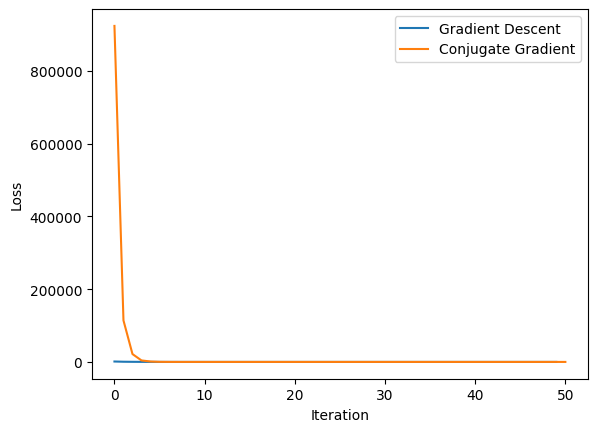

In [5]:
def conjugate_gradient(A, b, x0, n_iter):
    x = x0.copy()
    r = b - A @ x
    p = r.copy()
    losses = [0.5 * r.T @ r]
    for _ in range(n_iter):
        Ap = A @ p
        alpha = (r.T @ r) / (p.T @ Ap)
        x += alpha * p
        r_new = r - alpha * Ap
        beta = (r_new.T @ r_new) / (r.T @ r)
        p = r_new + beta * p
        r = r_new
        losses.append(0.5 * r.T @ r)
    return x, losses

A = X.T @ X
b = X.T @ y
w0 = np.zeros(n_features)
w_cg, losses_cg = conjugate_gradient(A, b, w0, n_iter=50)

plt.plot(losses_gd, label='Gradient Descent')
plt.plot(losses_cg, label='Conjugate Gradient')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## RMSProp

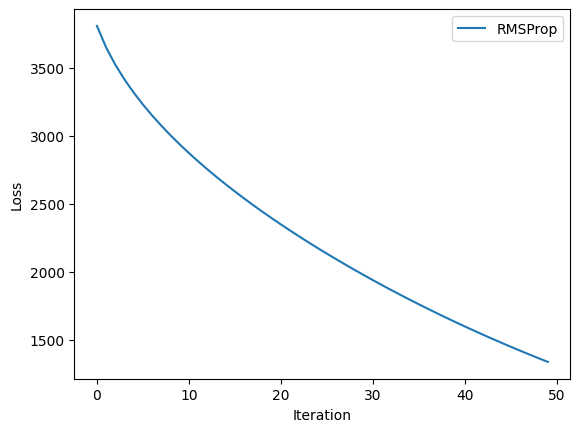

In [6]:
def rmsprop(w0, lr=0.01, beta=0.9, eps=1e-8, n_iter=50):
    w = w0.copy()
    s = np.zeros_like(w)
    losses = []
    for _ in range(n_iter):
        g = grad_F(w)
        s = beta * s + (1 - beta) * g**2
        w -= lr * g / (np.sqrt(s) + eps)
        losses.append(F(w))
    return w, losses

w_rms, losses_rms = rmsprop(np.zeros(n_features))
plt.plot(losses_rms, label='RMSProp')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Adam

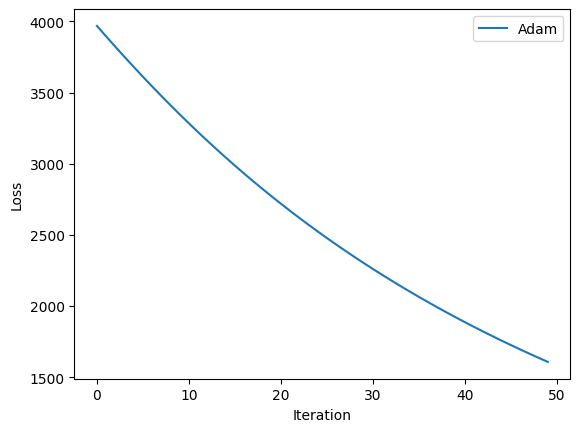

In [12]:
def adam(w0, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8, n_iter=50):
    w = w0.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    losses = []
    for t in range(1, n_iter+1):
        g = grad_F(w)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        w -= lr * m_hat / (np.sqrt(v_hat) + eps)
        losses.append(F(w))
    return w, losses

w_adam, losses_adam = adam(np.zeros(n_features))
plt.plot(losses_adam, label='Adam')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

La Phase 3 ISTA et FISTA

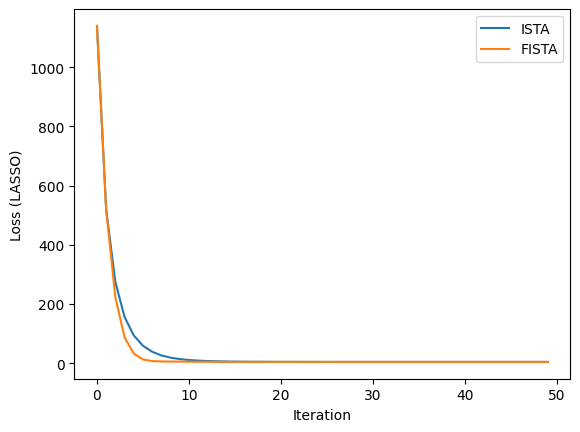

In [13]:
# -----------------------------
# ISTA et FISTA pour LASSO
# -----------------------------

# Paramètres LASSO
lambda_reg = 0.1  # régularisation L1

def soft_thresholding(x, tau):
    """Opérateur de seuillage doux"""
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.0)

# -----------------------------
# ISTA
# -----------------------------
def ista(w0, lr, n_iter, lam):
    w = w0.copy()
    losses = []
    for _ in range(n_iter):
        grad = X.T @ (X @ w - y)
        w = soft_thresholding(w - lr * grad, lr * lam)
        losses.append(0.5 * norm(X @ w - y)**2 + lam * np.sum(np.abs(w)))
    return w, losses

# -----------------------------
# FISTA
# -----------------------------
def fista(w0, lr, n_iter, lam):
    w = w0.copy()
    z = w0.copy()
    t = 1
    losses = []
    for _ in range(n_iter):
        grad = X.T @ (X @ z - y)
        w_new = soft_thresholding(z - lr * grad, lr * lam)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = w_new + ((t - 1) / t_new) * (w_new - w)
        w = w_new
        t = t_new
        losses.append(0.5 * norm(X @ w - y)**2 + lam * np.sum(np.abs(w)))
    return w, losses

# -----------------------------
# Exécution
# -----------------------------
w0 = np.zeros(n_features)
lr = 1 / L  # pas basé sur Lipschitz

w_ista, losses_ista = ista(w0, lr, n_iter=50, lam=lambda_reg)
w_fista, losses_fista = fista(w0, lr, n_iter=50, lam=lambda_reg)

# -----------------------------
# Visualisation
# -----------------------------
plt.plot(losses_ista, label='ISTA')
plt.plot(losses_fista, label='FISTA')
plt.xlabel('Iteration')
plt.ylabel('Loss (LASSO)')
plt.legend()
plt.show()
